In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
#have the updated version of fastai and duckduckgo_search
!pip install -Uqq fastai duckduckgo_search

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [20]:
#import required libraries
from fastcore.all import *
from duckduckgo_search import DDGS

ddgs = DDGS()

def search_images (term, max_images = 50):
    print(f"Searching for '{term}' images")
    return L(ddgs.images(keywords = term, max_results = max_images)).itemgot('image')

Searching for 'humback whale' images


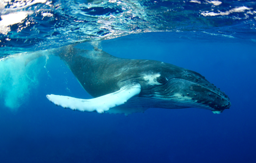

In [21]:
#importing required libraries from fastdownload and fastai
from fastdownload import download_url
from fastai.vision.all import *

#downloading url of the search image 1
download_url(search_images('humback whale', max_images = 1)[0], 'humback whale.jpg', show_progress = False)
Image.open('humback whale.jpg').to_thumb(256,256)


Searching for 'Beluga whale' images


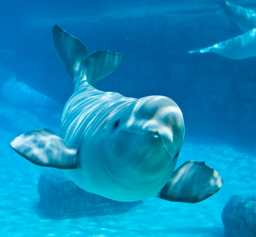

In [22]:
#downloading url of the search image 2
download_url(search_images('Beluga whale', max_images = 1)[0], 'Beluga whale.jpg', show_progress = False)
Image.open('Beluga whale.jpg').to_thumb(256,256)

Searching for 'Orca whale' images


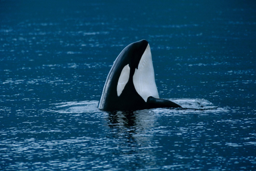

In [23]:
#downloading url of the search image 3
download_url(search_images('Orca whale', max_images = 1)[0], 'Orca whale.jpg', show_progress = False)
Image.open('Orca whale.jpg').to_thumb(256,256)

In [24]:
#Downloading images of 3 different whale types to its respective folder inside whales folder
whale_types = 'humback', 'orca', 'beluga'
path = Path('whale')
#from time import sleep

if not path.exists():
    path.mkdir()
    for o in whale_types:
        dest = (path/o)
        dest.mkdir(exist_ok = True)
        download_images(dest, urls=search_images(f'{o} whale photo'))
        resize_images(path/o, max_size = 400, dest = path/o)

In [25]:
#identifying corrupt images and deleting them
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

In [26]:
#Creating a datablock object
whales = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = Resize(128)
)

In [27]:

whales = whales.new(
    item_tfms = RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms = aug_transforms()
)

dls = whales.dataloaders(path)

In [29]:
#Creating our learner
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.678383,4.224154,0.740741,00:09


epoch,train_loss,valid_loss,error_rate,time
0,1.631805,3.297255,0.740741,00:13
1,1.605091,2.070776,0.592593,00:13
2,1.517346,1.008773,0.444444,00:14
3,1.219642,0.500194,0.222222,00:13
4,1.022748,0.295896,0.111111,00:13
5,0.872749,0.207560,0.074074,00:14


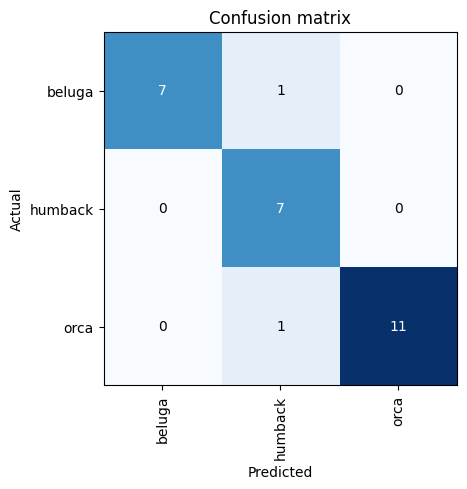

In [30]:
#Creating confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
#Checking out the top 6 losses
interp.plot_top_losses(6, nrows = 2)

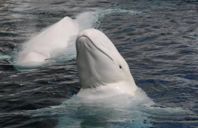

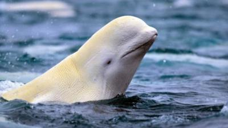

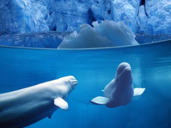

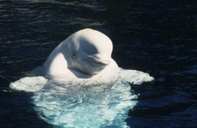

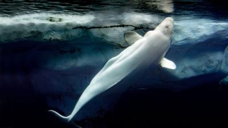

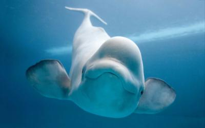

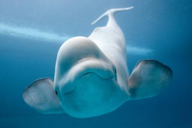

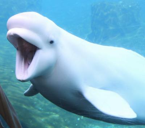

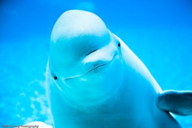

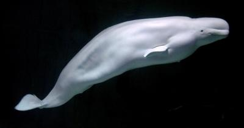

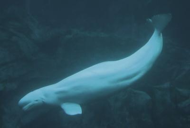

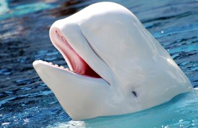

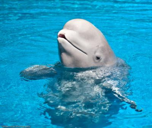

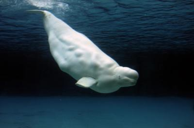

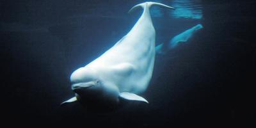

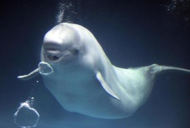

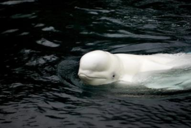

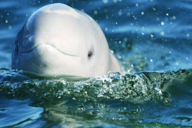

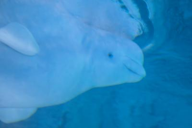

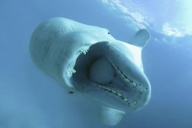

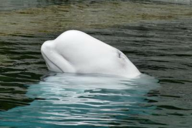

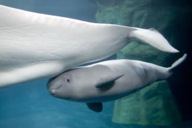

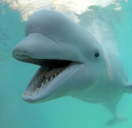

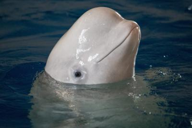

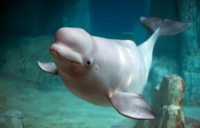

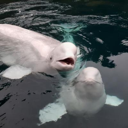

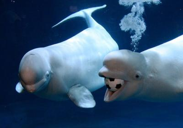

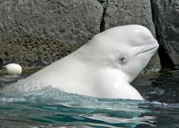

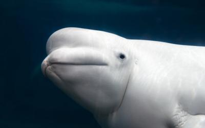

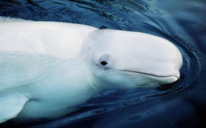

In [31]:
#Looking at high losses images and correcting them manually
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#To delete (unlink) images selected for deletion
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

#To move images that were selected for different category
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/whale)

In [32]:
#Exporting the model
learn.export()

In [33]:
#Checking if that model (export.pkl) file exists 
path = Path()
path.ls(file_exts= ".pkl")

(#1) [Path('export.pkl')]

In [34]:
#Using model to make predictions
learn_inf = load_learner(path/'export.pkl')

In [35]:
#Lets try running the first image that we downloaded
learn_inf.predict('humback whale.jpg')

('humback', tensor(1), tensor([1.0092e-04, 9.9970e-01, 1.9803e-04]))

In [ ]:
learn_inf.dls.vocab